## Bitcoin Price Prediction

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
from preprocessing.data_preprocessor import FinancialDataPreprocessor

preprocessor = FinancialDataPreprocessor()

preprocessor.load_data(
    bitcoin_path=r"C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\Bitcoin Historical Data.csv",
    usd_path=r"C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\dolar.csv",
    gold_path=r"C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\XAU_USD Geçmiş Verileri.csv",
)

merged_df = preprocessor.merge_data()

merged_df.to_csv(
    r"C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\merged_data.csv", index=False
)

data_info = preprocessor.get_data_info()
print("Data Shape:", data_info["shape"])
print("Date Range:", data_info["date_range"])
print("Unique Dates:", data_info["unique_dates"])
print("Missing Values:", data_info["missing_values"])
merged_df.head()

Data Shape: (2892, 14)
Date Range: (Timestamp('2017-01-29 00:00:00'), Timestamp('2024-12-29 00:00:00'))
Unique Dates: 2892
Missing Values: {'Date': 0, 'Price': 0, 'Open': 0, 'High': 0, 'Low': 0, 'Vol.': 0, 'Change %': 0, 'usd_buy': 0, 'usd_sell': 0, 'gold_Price': 1, 'gold_Open': 1, 'gold_High': 1, 'gold_Low': 1, 'gold_Change': 1}


,Date,Price,Open,High,Low,Vol.,Change %,usd_buy,usd_sell,gold_Price,gold_Open,gold_High,gold_Low,gold_Change
0,2017-01-29,914.5,918.5,922.4,912.7,11050.0,-0.43,3.83,3.84,NaN,NaN,NaN,NaN,NaN
1,2017-01-30,920.7,914.5,922.3,911.5,19060.0,0.68,3.88,3.88,1195.35,1192.85,1199.88,1188.15,0.31
2,2017-01-31,965.5,920.7,967.5,917.4,54670.0,4.86,3.83,3.84,1210.63,1195.38,1215.49,1193.83,1.28
3,2017-02-01,982.4,965.5,986.6,959.8,45220.0,1.75,3.79,3.79,1209.49,1210.89,1213.59,1198.12,-0.09
4,2017-02-02,1004.0,982.4,1009.1,973.5,50860.0,2.19,3.77,3.78,1215.93,1209.53,1225.41,1208.26,0.53


In [3]:
merged_df.tail()

,Date,Price,Open,High,Low,Vol.,Change %,usd_buy,usd_sell,gold_Price,gold_Open,gold_High,gold_Low,gold_Change
2887,2024-12-25,99391.3,98661.9,99514.1,97651.9,39800.0,0.73,35.18,35.24,2613.20,2613.07,2621.83,2609.92,0.01
2888,2024-12-26,95777.7,99389.4,99922.5,95193.3,74600.0,-3.64,35.22,35.28,2634.43,2619.80,2639.40,2614.13,0.81
2889,2024-12-27,94275.9,95776.4,97243.3,93472.8,85120.0,-1.57,35.20,35.27,2620.00,2634.59,2638.74,2611.30,-0.55
2890,2024-12-28,95284.5,94274.9,95684.3,94124.7,32970.0,1.07,35.20,35.27,2620.00,2634.59,2638.74,2611.30,-0.55
2891,2024-12-29,93838.4,95282.6,95315.4,93605.1,38130.0,-1.52,35.20,35.27,2620.00,2634.59,2638.74,2611.30,-0.55


### Corr matrix

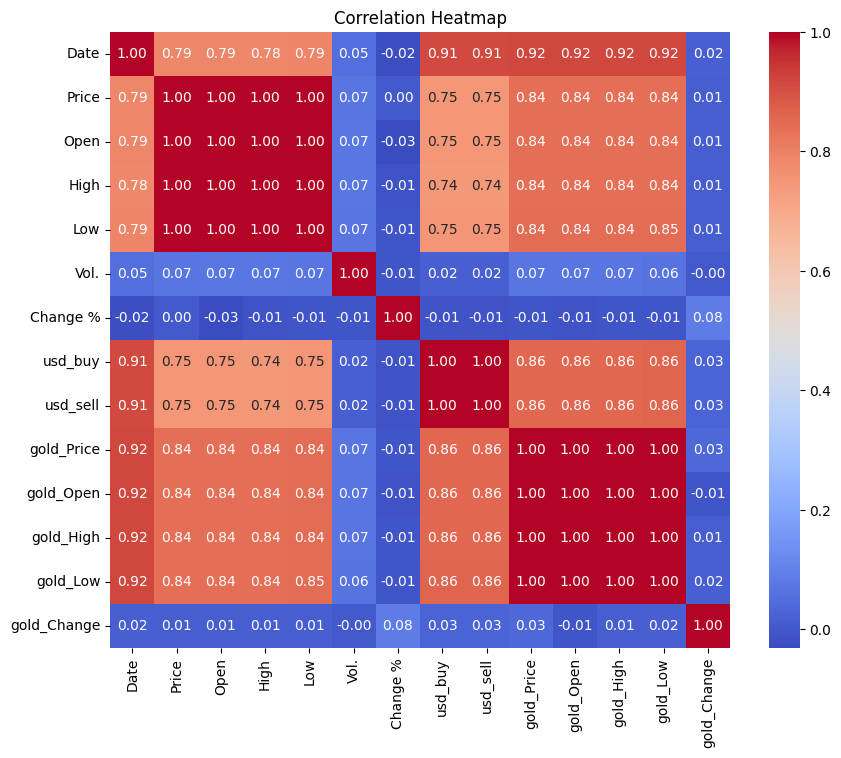

In [4]:

correlation_matrix = merged_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()


In [5]:
from visualization.data_eda import FinancialDataEDA

eda = FinancialDataEDA(merged_df)

time_series = eda.plot_time_series()
time_series.show()

In [6]:
correlation_matrix = eda.plot_correlation_matrix()
correlation_matrix.show()

In [7]:
# returns = eda.plot_returns_distribution()
# returns.show()

detailed_corr = eda.get_detailed_correlations()
print("\nTop 10 Strongest Correlations:")
print(detailed_corr.head(15))


Top 10 Strongest Correlations:
         Asset 1        Asset 2  Correlation
0   USD Buy Rate  USD Sell Rate     1.000000
0      Gold Open      Gold High     0.999651
0     Gold Price       Gold Low     0.999645
0     Gold Price      Gold High     0.999565
0      Gold Open       Gold Low     0.999517
0  Bitcoin Price   Bitcoin High     0.999503
0      Gold High       Gold Low     0.999473
0   Bitcoin Open   Bitcoin High     0.999446
0  Bitcoin Price    Bitcoin Low     0.999372
0   Bitcoin Open    Bitcoin Low     0.999171
0     Gold Price      Gold Open     0.999082
0   Bitcoin High    Bitcoin Low     0.998980
0  Bitcoin Price   Bitcoin Open     0.998827
0  USD Sell Rate       Gold Low     0.859040
0   USD Buy Rate       Gold Low     0.859039


In [11]:
# risk metrics
# risk_metrics = eda.generate_risk_metrics()
# for asset, metrics in risk_metrics.items():
#    print(f"\n{asset} Metrics:")
#    for metric, value in metrics.items():
#        print(f"{metric}: {value:.2f}")

In [8]:
from preprocessing.model_preprocessor import FinancialDataPreprocessor


preprocessor = FinancialDataPreprocessor(lookback_period=30)

processed_data = preprocessor.prepare_data(
    df=merged_df,
    train_start="2023-09-01",
    train_end="2024-09-14",
    test_start="2024-09-15",
    test_end="2024-09-30",
)

train_data = processed_data["train"]
test_data = processed_data["test"]

preprocessor.check_data_quality(train_data, test_data)

Training veri boyutu: (380, 16)
Test veri boyutu: (16, 16)

Veri Kalitesi Raporu:
--------------------------------------------------

Train veri boyutu: (380, 46)
Test veri boyutu: (16, 46)

Train seti eksik değer sayıları:
Series([], dtype: int64)

Test seti eksik değer sayıları:
Series([], dtype: int64)

Train seti tarih aralığı:
Başlangıç: 2023-09-01 00:00:00
Bitiş: 2024-09-14 00:00:00

Test seti tarih aralığı:
Başlangıç: 2024-09-15 00:00:00
Bitiş: 2024-09-30 00:00:00


### Feature Selection

In [ ]:
train_data.columns

In [ ]:
test_data.columns

In [9]:
#selected_features = ['Date', 'Price','Open', 'High', 'Low', 'Vol.', 'Change %', 'usd_buy',
#'usd_sell', 'gold_Price', 'gold_Open', 'gold_High', 'gold_Low',
#'gold_Change', 'RSI', 'MA_7', 'EMA_7', 'MA_14',
#'EMA_14','Volume_MA','BTC_Gold_Ratio','BTC_USD_Ratio']

#'usd_sell', 'MA_14',

selected_features = ['Date', 'Price', 'High', 'usd_buy',
        'gold_Price', 'RSI', 'MA_7', 'BTC_Gold_Ratio','BTC_USD_Ratio']

train_data = train_data[selected_features]
test_data = test_data[selected_features]

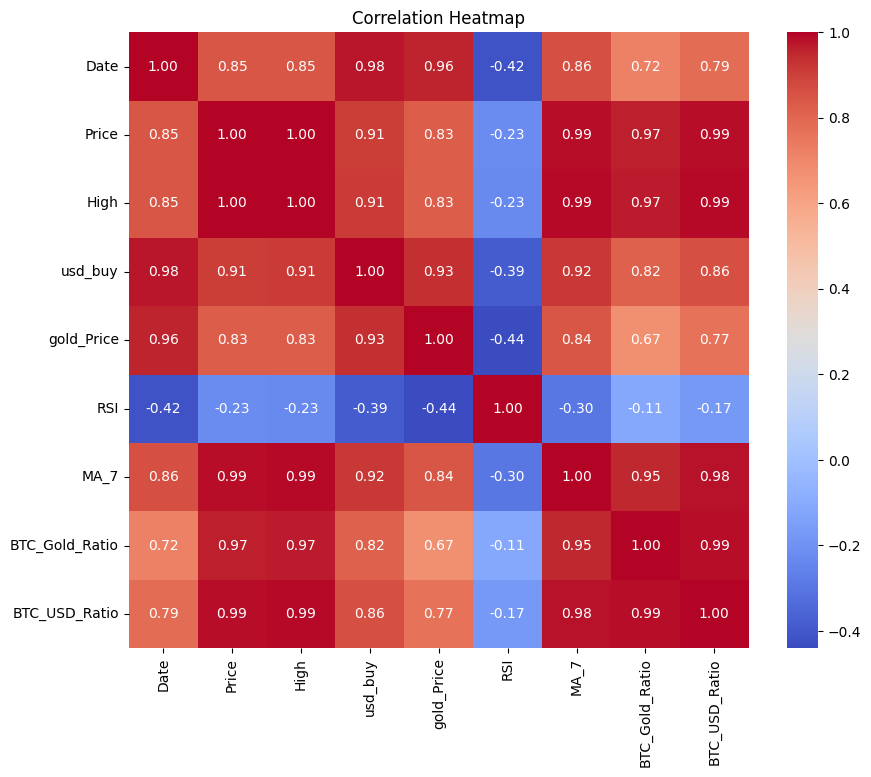

In [10]:
correlation_matrix = train_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Heatmap')
plt.show()


### Correlation After Feature Engineering  

In [11]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.colheader_justify", "center")

correlation_matrix = train_data.corr()

mask = np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)
high_corr_matrix = correlation_matrix.where(mask)

high_corr = (
    high_corr_matrix.stack()
    .reset_index()
    .rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Correlation"})
)


threshold = 0.8
high_corr_filtered = high_corr[high_corr["Correlation"].abs() >= threshold]

high_corr_filtered[["Feature 1", "Feature 2"]] = np.sort(
    high_corr_filtered[["Feature 1", "Feature 2"]], axis=1
)
high_corr_filtered = high_corr_filtered.drop_duplicates(
    subset=["Feature 1", "Feature 2"]
)

high_corr_filtered = high_corr_filtered.sort_values(
    by="Correlation", ascending=False
).reset_index(drop=True)
high_corr_filtered.index += 1
high_corr_filtered.index.name = "Index"

print(high_corr_filtered)

         Feature 1      Feature 2     Correlation
Index                                            
1                High          Price   0.998223  
2       BTC_USD_Ratio           High   0.990462  
3                High           MA_7   0.989804  
4       BTC_USD_Ratio          Price   0.987775  
5                MA_7          Price   0.986909  
6      BTC_Gold_Ratio  BTC_USD_Ratio   0.986238  
7       BTC_USD_Ratio           MA_7   0.980253  
8                Date        usd_buy   0.977104  
9      BTC_Gold_Ratio           High   0.968738  
10     BTC_Gold_Ratio          Price   0.965901  
11               Date     gold_Price   0.958759  
12     BTC_Gold_Ratio           MA_7   0.953168  
13         gold_Price        usd_buy   0.934368  
14               MA_7        usd_buy   0.918640  
15               High        usd_buy   0.910321  
16              Price        usd_buy   0.908353  
17      BTC_USD_Ratio        usd_buy   0.859770  
18               Date           MA_7   0.859739  


In [12]:
from model.models import FinancialModelPipeline

pipeline = FinancialModelPipeline(train_data, test_data)
pipeline.train_and_evaluate()


+-------------------+---------------+--------+-------+--------+---------+-----------+----------+-----------+
| Model             |   Scaled RMSE | RMSE   | MAE   | MAPE   |      R² | CV RMSE   | CV MAE   | CV MAPE   |
+===================+===============+========+=======+========+=========+===========+==========+===========+
| Linear_Regression |      0.039803 | 583    | 485   | 0.76%  |  0.9287 | 1,006     | 698      | 1.23%     |
+-------------------+---------------+--------+-------+--------+---------+-----------+----------+-----------+
| Decision_Tree     |      0.110921 | 1,625  | 1,329 | 2.11%  |  0.4466 | 5,136     | 3,827    | 7.05%     |
+-------------------+---------------+--------+-------+--------+---------+-----------+----------+-----------+
| SVR               |      0.219678 | 3,218  | 2,844 | 4.43%  | -1.1706 | 7,422     | 6,131    | 11.08%    |
+-------------------+---------------+--------+-------+--------+---------+-----------+----------+-----------+
| Random_Forest   

In [13]:
from visualization.model_visualizations import ModelVisualizer

visualizer = ModelVisualizer(pipeline)

# model metrics
fig_metrics = visualizer.plot_model_metrics()
fig_metrics.show()

# best model
fig_best = visualizer.plot_best_model_predictions()
fig_best.show()

# all predictions
fig_all = visualizer.plot_all_predictions()
fig_all.show()

### Feature Importance

In [14]:
# Decision_Tree, Random_Forest, XGBoost, LightGBM, CatBoost, AdaBoost
fig_importance = visualizer.plot_feature_importance("LightGBM")
if fig_importance:
    fig_importance.show()

### Model Parametre Tuning

In [15]:
# tune selected models
# pipeline.tune_models(['Random_Forest', 'XGBoost'])

# tune all models
# pipeline.tune_models()

# tuning results
# pipeline.train_and_evaluate()

### LSTM

In [16]:
import json
from datetime import datetime
from model.lstm_model import FinancialLSTM
from preprocessing.lstm_model_preprocessor import LSTMDataPreprocessor
from preprocessing.model_preprocessor import FinancialDataPreprocessor


df = pd.read_csv(r"C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\merged_data.csv")
df["Date"] = pd.to_datetime(df["Date"])


sequence_length = 20

data_preprocessor = FinancialDataPreprocessor(lookback_period=30)
lstm_preprocessor = LSTMDataPreprocessor(
    sequence_length=sequence_length,
    target_column="Price",
    feature_columns=[
        "Price",
        "High",
        "Low",
        "Vol.",
        "MA_7",
        "RSI",
        "MACD",
        "BB_middle",
        "Price_Momentum_1",
        "Price_Momentum_3",
    ],
)

preprocessed_data = data_preprocessor.prepare_data(
    df=df,
    train_start="2022-01-01",
    train_end="2024-08-15",  
    test_start="2024-08-16",
    test_end="2024-09-30",
)

lstm_data = lstm_preprocessor.prepare_lstm_data(preprocessed_data)

model = FinancialLSTM(
    sequence_length=sequence_length,
    epochs=150,
    batch_size=32,
    lstm_units=[128, 64, 32],
    dropout_rate=0.1,
)

metrics = model.train(lstm_data)
print("\nTraining metrics:", metrics)

predictions = model.predict(lstm_data["test"]["X"])
predictions = lstm_preprocessor.inverse_transform_predictions(predictions)

test_dates = preprocessed_data["test"]["Date"].values[
    sequence_length : len(predictions) + sequence_length
]
y_true = preprocessed_data["test"][lstm_preprocessor.target_column].values[
    sequence_length : len(predictions) + sequence_length
]

model.plot_predictions(test_dates, y_true, predictions.flatten())

eval_metrics = model.evaluate_predictions(y_true, predictions.flatten())
print("\nTest Set Performance Metrics:")
print(f"MAE: ${eval_metrics['mae']:,.2f}")
print(f"RMSE: ${eval_metrics['rmse']:,.2f}")
print(f"R2 Score: {eval_metrics['r2']:.4f}")
print(f"MAPE: {eval_metrics['mape']:.2f}%")


performance_log = {
    "timestamp": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "metrics": eval_metrics,
    "model_params": {
        "sequence_length": sequence_length,
        "lstm_units": [128, 64, 32],
        "dropout_rate": 0.1,
        "batch_size": 32,
        "epochs": 150,
    },
    "train_period": f"{preprocessed_data['train']['Date'].iloc[0]} to {preprocessed_data['train']['Date'].iloc[-1]}",
    "test_period": f"{preprocessed_data['test']['Date'].iloc[0]} to {preprocessed_data['test']['Date'].iloc[-1]}",
}

with open("model\lstm_performance_log.json", "w") as f:
    json.dump(performance_log, f, indent=4)

print("\nModel performance saved to 'model_performance_log.json'")

Training veri boyutu: (958, 14)
Test veri boyutu: (46, 14)
Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step - loss: 1.3886 - mae: 0.8351 - val_loss: 2.0547 - val_mae: 1.4184 - learning_rate: 0.0010
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.4934 - mae: 0.4053 - val_loss: 1.9904 - val_mae: 1.3910 - learning_rate: 0.0010
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3941 - mae: 0.3228 - val_loss: 1.6508 - val_mae: 1.2332 - learning_rate: 0.0010
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.3530 - mae: 0.2795 - val_loss: 1.2714 - val_mae: 1.0313 - learning_rate: 0.0010
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3245 - mae: 0.2458 - val_loss: 0.9531 - val_mae: 0.8377 - learning_rate: 0.0010
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.3096 - mae: 0.2292 - val_loss: 0.7777 - val_mae: 0.7095 - learning_rate: 0.0010
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2840 - mae: 0.1976 - val_lo


Training metrics: {'train_loss': 0.22467856109142303, 'train_mae': 0.1521480828523636, 'val_loss': 0.23388317227363586, 'val_mae': 0.17684203386306763}



Test Set Performance Metrics:
MAE: $1,771.59
RMSE: $2,342.34
R2 Score: 0.5917
MAPE: 3.01%

Model performance saved to 'model_performance_log.json'


### Autogluon

In [ ]:
from model.automl_autogluon import BitcoinPricePredictor

PARAMS = {
    'data_path': r'C:\Users\enesm\OneDrive\Masaüstü\tubitak\data\merged_data.csv',  
    'train_start':"2022-01-01",
    'train_end':"2024-09-14",
    'test_start':"2024-09-15",
    'test_end':"2024-09-30",
    'time_limit': 600  
}

predictor = BitcoinPricePredictor()

print("Veri hazırlanıyor...")
train_data, test_data = predictor.prepare_data(
    PARAMS['data_path'],
    PARAMS['train_start'],
    PARAMS['train_end'],
    PARAMS['test_start'],
    PARAMS['test_end']
)

print("\nModel eğitimi başlıyor...")
predictor.train_model(time_limit=PARAMS['time_limit'])

print("\nModel değerlendiriliyor...")
results = predictor.evaluate_model()

print("\nModel Performans Metrikleri:")
print("-" * 30)
for metric, value in results['metrics'].items():
    print(f"{metric}: {value:.4f}")

plt.figure(figsize=(12, 6))

importance_df = results['feature_importance']
if isinstance(importance_df, pd.DataFrame):
    importance_series = importance_df.iloc[:, 0]
else:
    importance_series = importance_df

importance_series = importance_series.sort_values(ascending=True)
top_10_features = importance_series.tail(10)

y_pos = np.arange(len(top_10_features))
plt.barh(y_pos, top_10_features.values)
plt.yticks(y_pos, top_10_features.index)
plt.title('En Önemli 10 Feature')
plt.xlabel('Önem Skoru')
plt.tight_layout()
plt.show()

predictions_df = results['predictions']
plt.figure(figsize=(15, 7))
plt.plot(test_data['Date'].values, predictions_df['actual'], label='Gerçek Değer', alpha=0.7)
plt.plot(test_data['Date'].values, predictions_df['predicted'], label='Tahmin', alpha=0.7)
plt.title('Bitcoin Fiyat Tahminleri vs Gerçek Değerler')
plt.xlabel('Tarih')
plt.ylabel('Fiyat')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
errors = predictions_df['actual'] - predictions_df['predicted']
sns.histplot(errors, kde=True)
plt.title('Tahmin Hatalarının Dağılımı')
plt.xlabel('Hata')
plt.ylabel('Frekans')
plt.tight_layout()
plt.show()

results_df = pd.DataFrame({
    'Date': test_data['Date'],
    'Actual': predictions_df['actual'],
    'Predicted': predictions_df['predicted'],
    'Error': errors
})

results_path = r'C:\Users\enesm\OneDrive\Masaüstü\tubitak\src\model\autogluon_predictions.csv'
results_df.to_csv(results_path, index=False)
print(f"\nTahminler '{results_path}' dosyasına kaydedildi.")